In [1]:
import torch
import numpy as np
from torch import nn
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue

In [2]:
#直接导入出现http403错误
from six.moves import urllib
# 直接导入出现http403错误
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [3]:
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [4]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


In [5]:
train_input[0].shape

torch.Size([2, 14, 14])

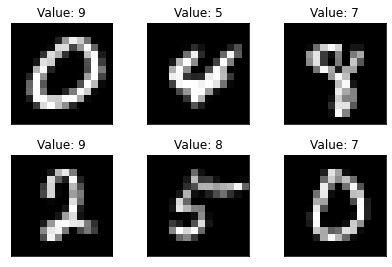

In [6]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray')
  plt.title("Value: {}".format(train_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [7]:
# 将两个图片拼接成一个1*392的tensor，为进入MLP网络进行准备。
print(train_input.shape)
tran_train_input=train_input.view(-1,2*14*14)
print(tran_train_input.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 392])


In [8]:
#同理对测试数据集进行相同的操作
tran_test_input=test_input.view(-1,2*14*14)
print(tran_test_input.shape)

torch.Size([1000, 392])


In [9]:
# class MLP_Net(nn.Module):
#     def __init__(self, num_hidden_1,num_hidden_2,num_hidden_3,num_hidden_4):
#         super(Test_MLPmodel, self).__init__()
#         self.linear1 = nn.Linear(2*14*14, 300)
#         self.linear2 = nn.Linear(300, 200)
#         self.linear3 = nn.Linear (200, 100)
#         self.linear4 = nn.Linear (100, 50)
#         self.linear_out = nn.Linear(num_hidden_4,2)

#     def forward(self, x):
#         x = F.relu(self.linear1(x.view(-1,2*14*14)))
#         x = F.relu(self.linear2(x))
#         x = F.relu(self.linear3(x))
#         x = F.relu(self.linear4(x))
#         x = self.linear_out(x)       
#         return x

In [10]:
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        self.linear1 = nn.Linear(2*14*14, 300)
        self.linear2 = nn.Linear(300, 200)
        self.linear3 = nn.Linear (200, 100)
        self.linear4 = nn.Linear (100, 50)
        self.linear5 = nn.Linear (50, 20)
        self.linear_out = nn.Linear(20,2)
        # training parameter
        self.batch_size = 20
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        x = F.relu(self.linear1(x.view(-1,2*14*14)))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = self.linear_out(x)       
        return x
     # Training Function

    def trainer(self, train_input, train_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        start_time = time.time()
        self.train()
        for epoch in range(self.num_epochs):
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #清零梯度
                loss.backward()                                #反向求梯度
                self.optimizer.step()

                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
         # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #测试模型
        self.eval()      #测试模式，关闭正则化
        errors = 0
        for idx in range(0,input_data.size(0),self.batch_size):
            input_batch=input_data.narrow(0,idx,self.batch_size)
            outputs = self(input_batch)
            _, predicted = torch.max(outputs, 1)   #返回值和索引
            target_labels = target.narrow(0, idx, self.batch_size)
            errors += torch.sum(predicted != target_labels)

        return float(errors)*100/input_data.size(0)
    def save_model(self,model_name):
        """
        Save the model to this folder
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+model_name)

In [11]:
my_model = MLP_Net()
my_model.save_model('MLP_Net.pth')

In [12]:
# train the model
# my_model.trainer(tran_test_input, train_target)

Epoch: 001/025 | Batch 000/1000 | Loss: 0.719313
Epoch: 001/025 | Batch 100/1000 | Loss: 0.815643
Epoch: 001/025 | Batch 200/1000 | Loss: 0.674651
Epoch: 001/025 | Batch 300/1000 | Loss: 0.689790
Epoch: 001/025 | Batch 400/1000 | Loss: 0.705986
Epoch: 001/025 | Batch 500/1000 | Loss: 0.776399
Epoch: 001/025 | Batch 600/1000 | Loss: 0.689004
Epoch: 001/025 | Batch 700/1000 | Loss: 0.700999
Epoch: 001/025 | Batch 800/1000 | Loss: 0.740349
Epoch: 001/025 | Batch 900/1000 | Loss: 0.699651
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/1000 | Loss: 0.840973
Epoch: 002/025 | Batch 100/1000 | Loss: 0.709207
Epoch: 002/025 | Batch 200/1000 | Loss: 0.670301
Epoch: 002/025 | Batch 300/1000 | Loss: 0.702534
Epoch: 002/025 | Batch 400/1000 | Loss: 0.650407
Epoch: 002/025 | Batch 500/1000 | Loss: 0.818234
Epoch: 002/025 | Batch 600/1000 | Loss: 0.605942
Epoch: 002/025 | Batch 700/1000 | Loss: 0.684731
Epoch: 002/025 | Batch 800/1000 | Loss: 0.688393
Epoch: 002/025 | Batch 900/1000 | Loss: 0.6967

Epoch: 017/025 | Batch 800/1000 | Loss: 0.183072
Epoch: 017/025 | Batch 900/1000 | Loss: 0.117271
Time elapsed: 0.03 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.033341
Epoch: 018/025 | Batch 100/1000 | Loss: 0.050317
Epoch: 018/025 | Batch 200/1000 | Loss: 0.129350
Epoch: 018/025 | Batch 300/1000 | Loss: 0.050803
Epoch: 018/025 | Batch 400/1000 | Loss: 0.045798
Epoch: 018/025 | Batch 500/1000 | Loss: 0.035254
Epoch: 018/025 | Batch 600/1000 | Loss: 0.129360
Epoch: 018/025 | Batch 700/1000 | Loss: 0.180563
Epoch: 018/025 | Batch 800/1000 | Loss: 0.052348
Epoch: 018/025 | Batch 900/1000 | Loss: 0.007700
Time elapsed: 0.03 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.005495
Epoch: 019/025 | Batch 100/1000 | Loss: 0.012790
Epoch: 019/025 | Batch 200/1000 | Loss: 0.037438
Epoch: 019/025 | Batch 300/1000 | Loss: 0.195293
Epoch: 019/025 | Batch 400/1000 | Loss: 0.003301
Epoch: 019/025 | Batch 500/1000 | Loss: 0.084920
Epoch: 019/025 | Batch 600/1000 | Loss: 0.000893
Epoch: 019/025 | Batch 

In [19]:
# output the train error and test error
# print("Train error : %.1f%% \nTest error : %.1f%%" %
#       (my_model.compute_error(tran_train_input, train_target),
#        my_model.compute_error(tran_test_input, test_target)))

# print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

Train error : 0.0% 
Test error : 17.3%
The total number of the parameters is: 204312


In [14]:
# def compute_accuracy(net, test_input,test_target):
# # 在训练模型的时候前面加上model.train()，在测试模型的时候前面加上model.eval(),以切换到测试模式
#     net.eval()
#     correct_pred, num_examples = 0, 0
# # 而with torch.no_grad()则主要是用于停止autograd模块的工作，
# # 以起到加速和节省显存的作用，具体行为就是停止gradient计算，
# # 从而节省了GPU算力和显存，但是并不会影响dropout和batchnorm层的行为。
#     with torch.no_grad():
# #         for features, targets in data_loader:
#         for idx in range(test_input.size(0)):
# #             features = features.view(-1, 14*14)
#             features= test_input[idx]
#             targets = test_target[idx]
#             logits, probas = net(features)
#             _, predicted_labels = torch.max(probas, 1)
#             num_examples += targets.size(0)
#             correct_pred += (predicted_labels == targets).sum()
#         return correct_pred.float()/num_examples * 100

In [20]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    tran_train_input=train_input.view(-1,2*14*14)
    tran_test_input=test_input.view(-1,2*14*14)
    my_model = MLP_Net()
    # train the model
    my_model.trainer(tran_train_input, train_target)
    # output the train error and test error
    print("Train error : %.1f%% \nTest error : %.1f%%" %
      (my_model.compute_error(tran_train_input, train_target),
       my_model.compute_error(tran_test_input, test_target)))
    print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))
    train_errors.append(my_model.compute_error(tran_train_input, train_target))
    test_errors.append(my_model.compute_error(tran_test_input, test_target))

Epoch: 001/025 | Batch 000/1000 | Loss: 0.790752
Epoch: 001/025 | Batch 100/1000 | Loss: 0.767673
Epoch: 001/025 | Batch 200/1000 | Loss: 0.659127
Epoch: 001/025 | Batch 300/1000 | Loss: 0.634099
Epoch: 001/025 | Batch 400/1000 | Loss: 0.639099
Epoch: 001/025 | Batch 500/1000 | Loss: 0.667664
Epoch: 001/025 | Batch 600/1000 | Loss: 1.000162
Epoch: 001/025 | Batch 700/1000 | Loss: 0.425860
Epoch: 001/025 | Batch 800/1000 | Loss: 0.643506
Epoch: 001/025 | Batch 900/1000 | Loss: 0.506112
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/1000 | Loss: 0.290680
Epoch: 002/025 | Batch 100/1000 | Loss: 0.382691
Epoch: 002/025 | Batch 200/1000 | Loss: 0.518659
Epoch: 002/025 | Batch 300/1000 | Loss: 0.526801
Epoch: 002/025 | Batch 400/1000 | Loss: 0.641019
Epoch: 002/025 | Batch 500/1000 | Loss: 0.511901
Epoch: 002/025 | Batch 600/1000 | Loss: 0.587581
Epoch: 002/025 | Batch 700/1000 | Loss: 0.287096
Epoch: 002/025 | Batch 800/1000 | Loss: 0.472177
Epoch: 002/025 | Batch 900/1000 | Loss: 0.2827

Epoch: 017/025 | Batch 900/1000 | Loss: 0.001372
Time elapsed: 0.03 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.077472
Epoch: 018/025 | Batch 100/1000 | Loss: 0.009597
Epoch: 018/025 | Batch 200/1000 | Loss: 0.035525
Epoch: 018/025 | Batch 300/1000 | Loss: 0.036187
Epoch: 018/025 | Batch 400/1000 | Loss: 0.046345
Epoch: 018/025 | Batch 500/1000 | Loss: 0.034227
Epoch: 018/025 | Batch 600/1000 | Loss: 0.184018
Epoch: 018/025 | Batch 700/1000 | Loss: 0.001543
Epoch: 018/025 | Batch 800/1000 | Loss: 0.007234
Epoch: 018/025 | Batch 900/1000 | Loss: 0.012196
Time elapsed: 0.03 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.003923
Epoch: 019/025 | Batch 100/1000 | Loss: 0.104608
Epoch: 019/025 | Batch 200/1000 | Loss: 0.008984
Epoch: 019/025 | Batch 300/1000 | Loss: 0.006147
Epoch: 019/025 | Batch 400/1000 | Loss: 0.058818
Epoch: 019/025 | Batch 500/1000 | Loss: 0.021643
Epoch: 019/025 | Batch 600/1000 | Loss: 0.000226
Epoch: 019/025 | Batch 700/1000 | Loss: 0.107466
Epoch: 019/025 | Batch 

Epoch: 009/025 | Batch 100/1000 | Loss: 0.130877
Epoch: 009/025 | Batch 200/1000 | Loss: 0.088768
Epoch: 009/025 | Batch 300/1000 | Loss: 0.100501
Epoch: 009/025 | Batch 400/1000 | Loss: 0.047660
Epoch: 009/025 | Batch 500/1000 | Loss: 0.009793
Epoch: 009/025 | Batch 600/1000 | Loss: 0.018071
Epoch: 009/025 | Batch 700/1000 | Loss: 0.238185
Epoch: 009/025 | Batch 800/1000 | Loss: 0.128609
Epoch: 009/025 | Batch 900/1000 | Loss: 0.044516
Time elapsed: 0.02 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.184441
Epoch: 010/025 | Batch 100/1000 | Loss: 0.112507
Epoch: 010/025 | Batch 200/1000 | Loss: 0.157008
Epoch: 010/025 | Batch 300/1000 | Loss: 0.083522
Epoch: 010/025 | Batch 400/1000 | Loss: 0.137283
Epoch: 010/025 | Batch 500/1000 | Loss: 0.113469
Epoch: 010/025 | Batch 600/1000 | Loss: 0.358977
Epoch: 010/025 | Batch 700/1000 | Loss: 0.091227
Epoch: 010/025 | Batch 800/1000 | Loss: 0.034214
Epoch: 010/025 | Batch 900/1000 | Loss: 0.061472
Time elapsed: 0.02 min
Epoch: 011/025 | Batch 

Epoch: 025/025 | Batch 800/1000 | Loss: 0.000043
Epoch: 025/025 | Batch 900/1000 | Loss: 0.000067
Time elapsed: 0.05 min
Total Training Time: 0.05 min
Train error : 0.0% 
Test error : 18.1%
The total number of the parameters is: 204312
Epoch: 001/025 | Batch 000/1000 | Loss: 0.672710
Epoch: 001/025 | Batch 100/1000 | Loss: 0.710425
Epoch: 001/025 | Batch 200/1000 | Loss: 0.618455
Epoch: 001/025 | Batch 300/1000 | Loss: 0.578670
Epoch: 001/025 | Batch 400/1000 | Loss: 0.532406
Epoch: 001/025 | Batch 500/1000 | Loss: 0.480445
Epoch: 001/025 | Batch 600/1000 | Loss: 0.522310
Epoch: 001/025 | Batch 700/1000 | Loss: 0.459847
Epoch: 001/025 | Batch 800/1000 | Loss: 0.392403
Epoch: 001/025 | Batch 900/1000 | Loss: 0.434759
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/1000 | Loss: 0.466344
Epoch: 002/025 | Batch 100/1000 | Loss: 0.317155
Epoch: 002/025 | Batch 200/1000 | Loss: 0.354621
Epoch: 002/025 | Batch 300/1000 | Loss: 0.465535
Epoch: 002/025 | Batch 400/1000 | Loss: 0.606514
Epoch:

Epoch: 016/025 | Batch 700/1000 | Loss: 0.000693
Epoch: 016/025 | Batch 800/1000 | Loss: 0.001834
Epoch: 016/025 | Batch 900/1000 | Loss: 0.000624
Time elapsed: 0.03 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.003089
Epoch: 017/025 | Batch 100/1000 | Loss: 0.002044
Epoch: 017/025 | Batch 200/1000 | Loss: 0.010803
Epoch: 017/025 | Batch 300/1000 | Loss: 0.003727
Epoch: 017/025 | Batch 400/1000 | Loss: 0.001888
Epoch: 017/025 | Batch 500/1000 | Loss: 0.000277
Epoch: 017/025 | Batch 600/1000 | Loss: 0.001949
Epoch: 017/025 | Batch 700/1000 | Loss: 0.001796
Epoch: 017/025 | Batch 800/1000 | Loss: 0.003201
Epoch: 017/025 | Batch 900/1000 | Loss: 0.000073
Time elapsed: 0.03 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.056820
Epoch: 018/025 | Batch 100/1000 | Loss: 0.000217
Epoch: 018/025 | Batch 200/1000 | Loss: 0.000147
Epoch: 018/025 | Batch 300/1000 | Loss: 0.000566
Epoch: 018/025 | Batch 400/1000 | Loss: 0.001454
Epoch: 018/025 | Batch 500/1000 | Loss: 0.000302
Epoch: 018/025 | Batch 

Epoch: 009/025 | Batch 100/1000 | Loss: 0.029176
Epoch: 009/025 | Batch 200/1000 | Loss: 0.144400
Epoch: 009/025 | Batch 300/1000 | Loss: 0.153534
Epoch: 009/025 | Batch 400/1000 | Loss: 0.147361
Epoch: 009/025 | Batch 500/1000 | Loss: 0.065773
Epoch: 009/025 | Batch 600/1000 | Loss: 0.223272
Epoch: 009/025 | Batch 700/1000 | Loss: 0.128138
Epoch: 009/025 | Batch 800/1000 | Loss: 0.049109
Epoch: 009/025 | Batch 900/1000 | Loss: 0.071834
Time elapsed: 0.02 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.031711
Epoch: 010/025 | Batch 100/1000 | Loss: 0.017833
Epoch: 010/025 | Batch 200/1000 | Loss: 0.173486
Epoch: 010/025 | Batch 300/1000 | Loss: 0.010876
Epoch: 010/025 | Batch 400/1000 | Loss: 0.004304
Epoch: 010/025 | Batch 500/1000 | Loss: 0.019136
Epoch: 010/025 | Batch 600/1000 | Loss: 0.039643
Epoch: 010/025 | Batch 700/1000 | Loss: 0.009319
Epoch: 010/025 | Batch 800/1000 | Loss: 0.007203
Epoch: 010/025 | Batch 900/1000 | Loss: 0.094646
Time elapsed: 0.02 min
Epoch: 011/025 | Batch 

Epoch: 025/025 | Batch 200/1000 | Loss: 0.006517
Epoch: 025/025 | Batch 300/1000 | Loss: 0.078987
Epoch: 025/025 | Batch 400/1000 | Loss: 0.004276
Epoch: 025/025 | Batch 500/1000 | Loss: 0.001105
Epoch: 025/025 | Batch 600/1000 | Loss: 0.008426
Epoch: 025/025 | Batch 700/1000 | Loss: 0.000061
Epoch: 025/025 | Batch 800/1000 | Loss: 0.000372
Epoch: 025/025 | Batch 900/1000 | Loss: 0.000339
Time elapsed: 0.05 min
Total Training Time: 0.05 min
Train error : 0.0% 
Test error : 18.5%
The total number of the parameters is: 204312
Epoch: 001/025 | Batch 000/1000 | Loss: 0.696470
Epoch: 001/025 | Batch 100/1000 | Loss: 0.677694
Epoch: 001/025 | Batch 200/1000 | Loss: 0.652922
Epoch: 001/025 | Batch 300/1000 | Loss: 0.628598
Epoch: 001/025 | Batch 400/1000 | Loss: 0.656930
Epoch: 001/025 | Batch 500/1000 | Loss: 0.821374
Epoch: 001/025 | Batch 600/1000 | Loss: 0.596308
Epoch: 001/025 | Batch 700/1000 | Loss: 0.490033
Epoch: 001/025 | Batch 800/1000 | Loss: 0.500372
Epoch: 001/025 | Batch 900/10

Time elapsed: 0.03 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.083460
Epoch: 017/025 | Batch 100/1000 | Loss: 0.000183
Epoch: 017/025 | Batch 200/1000 | Loss: 0.000920
Epoch: 017/025 | Batch 300/1000 | Loss: 0.000666
Epoch: 017/025 | Batch 400/1000 | Loss: 0.002180
Epoch: 017/025 | Batch 500/1000 | Loss: 0.011099
Epoch: 017/025 | Batch 600/1000 | Loss: 0.214512
Epoch: 017/025 | Batch 700/1000 | Loss: 0.006641
Epoch: 017/025 | Batch 800/1000 | Loss: 0.019976
Epoch: 017/025 | Batch 900/1000 | Loss: 0.014875
Time elapsed: 0.03 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.001188
Epoch: 018/025 | Batch 100/1000 | Loss: 0.001510
Epoch: 018/025 | Batch 200/1000 | Loss: 0.005283
Epoch: 018/025 | Batch 300/1000 | Loss: 0.007510
Epoch: 018/025 | Batch 400/1000 | Loss: 0.000646
Epoch: 018/025 | Batch 500/1000 | Loss: 0.009983
Epoch: 018/025 | Batch 600/1000 | Loss: 0.038830
Epoch: 018/025 | Batch 700/1000 | Loss: 0.000685
Epoch: 018/025 | Batch 800/1000 | Loss: 0.016163
Epoch: 018/025 | Batch 

Epoch: 007/025 | Batch 900/1000 | Loss: 0.061826
Time elapsed: 0.01 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.037251
Epoch: 008/025 | Batch 100/1000 | Loss: 0.241138
Epoch: 008/025 | Batch 200/1000 | Loss: 0.001388
Epoch: 008/025 | Batch 300/1000 | Loss: 0.057926
Epoch: 008/025 | Batch 400/1000 | Loss: 0.075545
Epoch: 008/025 | Batch 500/1000 | Loss: 0.069479
Epoch: 008/025 | Batch 600/1000 | Loss: 0.077933
Epoch: 008/025 | Batch 700/1000 | Loss: 0.024864
Epoch: 008/025 | Batch 800/1000 | Loss: 0.045561
Epoch: 008/025 | Batch 900/1000 | Loss: 0.051241
Time elapsed: 0.02 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.035786
Epoch: 009/025 | Batch 100/1000 | Loss: 0.037911
Epoch: 009/025 | Batch 200/1000 | Loss: 0.002150
Epoch: 009/025 | Batch 300/1000 | Loss: 0.048782
Epoch: 009/025 | Batch 400/1000 | Loss: 0.039108
Epoch: 009/025 | Batch 500/1000 | Loss: 0.044343
Epoch: 009/025 | Batch 600/1000 | Loss: 0.023742
Epoch: 009/025 | Batch 700/1000 | Loss: 0.034306
Epoch: 009/025 | Batch 

Epoch: 024/025 | Batch 500/1000 | Loss: 0.000053
Epoch: 024/025 | Batch 600/1000 | Loss: 0.000021
Epoch: 024/025 | Batch 700/1000 | Loss: 0.000000
Epoch: 024/025 | Batch 800/1000 | Loss: 0.000000
Epoch: 024/025 | Batch 900/1000 | Loss: 0.000003
Time elapsed: 0.06 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.000022
Epoch: 025/025 | Batch 100/1000 | Loss: 0.000004
Epoch: 025/025 | Batch 200/1000 | Loss: 0.000005
Epoch: 025/025 | Batch 300/1000 | Loss: 0.000003
Epoch: 025/025 | Batch 400/1000 | Loss: 0.000007
Epoch: 025/025 | Batch 500/1000 | Loss: 0.000031
Epoch: 025/025 | Batch 600/1000 | Loss: 0.000018
Epoch: 025/025 | Batch 700/1000 | Loss: 0.000000
Epoch: 025/025 | Batch 800/1000 | Loss: 0.000000
Epoch: 025/025 | Batch 900/1000 | Loss: 0.000002
Time elapsed: 0.06 min
Total Training Time: 0.06 min
Train error : 0.0% 
Test error : 17.3%
The total number of the parameters is: 204312
Epoch: 001/025 | Batch 000/1000 | Loss: 0.781901
Epoch: 001/025 | Batch 100/1000 | Loss: 0.833795
Epoch:

Epoch: 015/025 | Batch 400/1000 | Loss: 0.094471
Epoch: 015/025 | Batch 500/1000 | Loss: 0.068409
Epoch: 015/025 | Batch 600/1000 | Loss: 0.008722
Epoch: 015/025 | Batch 700/1000 | Loss: 0.010607
Epoch: 015/025 | Batch 800/1000 | Loss: 0.004091
Epoch: 015/025 | Batch 900/1000 | Loss: 0.042672
Time elapsed: 0.03 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.014427
Epoch: 016/025 | Batch 100/1000 | Loss: 0.019793
Epoch: 016/025 | Batch 200/1000 | Loss: 0.007275
Epoch: 016/025 | Batch 300/1000 | Loss: 0.017037
Epoch: 016/025 | Batch 400/1000 | Loss: 0.017558
Epoch: 016/025 | Batch 500/1000 | Loss: 0.018670
Epoch: 016/025 | Batch 600/1000 | Loss: 0.009439
Epoch: 016/025 | Batch 700/1000 | Loss: 0.004280
Epoch: 016/025 | Batch 800/1000 | Loss: 0.025733
Epoch: 016/025 | Batch 900/1000 | Loss: 0.002004
Time elapsed: 0.03 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.001573
Epoch: 017/025 | Batch 100/1000 | Loss: 0.000917
Epoch: 017/025 | Batch 200/1000 | Loss: 0.000039
Epoch: 017/025 | Batch 

Epoch: 006/025 | Batch 500/1000 | Loss: 0.028231
Epoch: 006/025 | Batch 600/1000 | Loss: 0.171891
Epoch: 006/025 | Batch 700/1000 | Loss: 0.165535
Epoch: 006/025 | Batch 800/1000 | Loss: 0.698161
Epoch: 006/025 | Batch 900/1000 | Loss: 0.101556
Time elapsed: 0.01 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.164916
Epoch: 007/025 | Batch 100/1000 | Loss: 0.085780
Epoch: 007/025 | Batch 200/1000 | Loss: 0.124049
Epoch: 007/025 | Batch 300/1000 | Loss: 0.090980
Epoch: 007/025 | Batch 400/1000 | Loss: 0.060987
Epoch: 007/025 | Batch 500/1000 | Loss: 0.025850
Epoch: 007/025 | Batch 600/1000 | Loss: 0.252642
Epoch: 007/025 | Batch 700/1000 | Loss: 0.372867
Epoch: 007/025 | Batch 800/1000 | Loss: 0.074315
Epoch: 007/025 | Batch 900/1000 | Loss: 0.049170
Time elapsed: 0.01 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.142898
Epoch: 008/025 | Batch 100/1000 | Loss: 0.128564
Epoch: 008/025 | Batch 200/1000 | Loss: 0.086841
Epoch: 008/025 | Batch 300/1000 | Loss: 0.095111
Epoch: 008/025 | Batch 

Time elapsed: 0.05 min
Epoch: 023/025 | Batch 000/1000 | Loss: 0.004534
Epoch: 023/025 | Batch 100/1000 | Loss: 0.005348
Epoch: 023/025 | Batch 200/1000 | Loss: 0.001718
Epoch: 023/025 | Batch 300/1000 | Loss: 0.001865
Epoch: 023/025 | Batch 400/1000 | Loss: 0.014225
Epoch: 023/025 | Batch 500/1000 | Loss: 0.000210
Epoch: 023/025 | Batch 600/1000 | Loss: 0.007079
Epoch: 023/025 | Batch 700/1000 | Loss: 0.001359
Epoch: 023/025 | Batch 800/1000 | Loss: 0.141414
Epoch: 023/025 | Batch 900/1000 | Loss: 0.002894
Time elapsed: 0.05 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.096702
Epoch: 024/025 | Batch 100/1000 | Loss: 0.000095
Epoch: 024/025 | Batch 200/1000 | Loss: 0.029252
Epoch: 024/025 | Batch 300/1000 | Loss: 0.229530
Epoch: 024/025 | Batch 400/1000 | Loss: 0.082370
Epoch: 024/025 | Batch 500/1000 | Loss: 0.004330
Epoch: 024/025 | Batch 600/1000 | Loss: 0.011605
Epoch: 024/025 | Batch 700/1000 | Loss: 0.000299
Epoch: 024/025 | Batch 800/1000 | Loss: 0.001706
Epoch: 024/025 | Batch 

Epoch: 014/025 | Batch 400/1000 | Loss: 0.033287
Epoch: 014/025 | Batch 500/1000 | Loss: 0.006484
Epoch: 014/025 | Batch 600/1000 | Loss: 0.008210
Epoch: 014/025 | Batch 700/1000 | Loss: 0.052656
Epoch: 014/025 | Batch 800/1000 | Loss: 0.007516
Epoch: 014/025 | Batch 900/1000 | Loss: 0.007807
Time elapsed: 0.03 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.035504
Epoch: 015/025 | Batch 100/1000 | Loss: 0.012880
Epoch: 015/025 | Batch 200/1000 | Loss: 0.106011
Epoch: 015/025 | Batch 300/1000 | Loss: 0.107255
Epoch: 015/025 | Batch 400/1000 | Loss: 0.020009
Epoch: 015/025 | Batch 500/1000 | Loss: 0.004491
Epoch: 015/025 | Batch 600/1000 | Loss: 0.197515
Epoch: 015/025 | Batch 700/1000 | Loss: 0.030714
Epoch: 015/025 | Batch 800/1000 | Loss: 0.010414
Epoch: 015/025 | Batch 900/1000 | Loss: 0.053196
Time elapsed: 0.03 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.180622
Epoch: 016/025 | Batch 100/1000 | Loss: 0.058305
Epoch: 016/025 | Batch 200/1000 | Loss: 0.064566
Epoch: 016/025 | Batch 

Time elapsed: 0.01 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.053774
Epoch: 007/025 | Batch 100/1000 | Loss: 0.014403
Epoch: 007/025 | Batch 200/1000 | Loss: 0.397144
Epoch: 007/025 | Batch 300/1000 | Loss: 0.968657
Epoch: 007/025 | Batch 400/1000 | Loss: 0.058434
Epoch: 007/025 | Batch 500/1000 | Loss: 0.612499
Epoch: 007/025 | Batch 600/1000 | Loss: 0.331236
Epoch: 007/025 | Batch 700/1000 | Loss: 0.320124
Epoch: 007/025 | Batch 800/1000 | Loss: 0.202638
Epoch: 007/025 | Batch 900/1000 | Loss: 0.032726
Time elapsed: 0.01 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.011231
Epoch: 008/025 | Batch 100/1000 | Loss: 0.017504
Epoch: 008/025 | Batch 200/1000 | Loss: 0.227118
Epoch: 008/025 | Batch 300/1000 | Loss: 0.194173
Epoch: 008/025 | Batch 400/1000 | Loss: 0.028860
Epoch: 008/025 | Batch 500/1000 | Loss: 0.274373
Epoch: 008/025 | Batch 600/1000 | Loss: 0.140275
Epoch: 008/025 | Batch 700/1000 | Loss: 0.127094
Epoch: 008/025 | Batch 800/1000 | Loss: 0.188752
Epoch: 008/025 | Batch 

Epoch: 023/025 | Batch 800/1000 | Loss: 0.000000
Epoch: 023/025 | Batch 900/1000 | Loss: 0.000009
Time elapsed: 0.05 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.000035
Epoch: 024/025 | Batch 100/1000 | Loss: 0.000001
Epoch: 024/025 | Batch 200/1000 | Loss: 0.000002
Epoch: 024/025 | Batch 300/1000 | Loss: 0.000008
Epoch: 024/025 | Batch 400/1000 | Loss: 0.000003
Epoch: 024/025 | Batch 500/1000 | Loss: 0.000009
Epoch: 024/025 | Batch 600/1000 | Loss: 0.000008
Epoch: 024/025 | Batch 700/1000 | Loss: 0.000082
Epoch: 024/025 | Batch 800/1000 | Loss: 0.000000
Epoch: 024/025 | Batch 900/1000 | Loss: 0.000007
Time elapsed: 0.06 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.000030
Epoch: 025/025 | Batch 100/1000 | Loss: 0.000001
Epoch: 025/025 | Batch 200/1000 | Loss: 0.000002
Epoch: 025/025 | Batch 300/1000 | Loss: 0.000006
Epoch: 025/025 | Batch 400/1000 | Loss: 0.000002
Epoch: 025/025 | Batch 500/1000 | Loss: 0.000007
Epoch: 025/025 | Batch 600/1000 | Loss: 0.000007
Epoch: 025/025 | Batch 

In [21]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error:',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.2683281572999748
The standard deviation of test error: 1.3009227494359539
The mean of train error: 0.1
The mean of test error: 19.06
